In [9]:
#Predictive Model 6 BUT Validation is Oct and Testing is Nov, Dec
#LSTM on Raw Data

import numpy 
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# fix random seed for reproducibility
numpy.random.seed(7)

dataframe = pandas.read_csv('Demand_Data3_Total_CV_2017_with_zeros.csv', usecols=[2,3,7,8])
PUL_list = numpy.unique(dataframe['PULocationID'])
RMSE_list = [0] * len(PUL_list)
MAPE_list = [0] * len(PUL_list)
Total_dataframe = dataframe

#delete warning flag
pandas.options.mode.chained_assignment = None  # default='warn'

for i in range(len(PUL_list)):    
    print(i/len(PUL_list))
    PULoc = PUL_list[i]
    
    #Training/testing Split
    dataframe = Total_dataframe
    dataframe = dataframe[dataframe['PULocationID'] == PULoc]
    dataframe = dataframe['passenger_count']
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    dataset = numpy.reshape(dataset, (len(dataset),1))


    #Scalar transform
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)


    dataframe = Total_dataframe
    dataframe = dataframe[dataframe['PULocationID'] == PULoc]
    dataframe['passenger_count'] = dataset
    dataframe = dataframe[dataframe['Month'] <= 10]
    dataframe2 = dataframe[dataframe['Month'] >= 10]
    dataframe['passenger_count']
    dataframe2 = dataframe2['passenger_count']
    dataset2 = dataframe2.values
    dataset2 = dataset2.astype('float32')
    dataset2 = numpy.reshape(dataset2, (len(dataset2),1))
    

    

    #Training/Testing Data (Train on Jan-Oct, Ttest on Nov-Dec) 370472 is index
    train_size = int(len(dataset) * 0.9)
    test_size = len(dataset) - train_size
    test2_size = len(dataset2)
    train = dataset[0:train_size,:]
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    test2 = dataset2

    def create_dataset(dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
        return numpy.array(dataX), numpy.array(dataY)

    # reshape into X=t and Y=t+1
    look_back = 1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    test2X, test2Y = create_dataset(test2, look_back)

    # reshape input to be [samples, time steps, features]
    trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    test2X = numpy.reshape(test2X, (test2X.shape[0], 1, test2X.shape[1]))



    # create and fit the LSTM network
    model = Sequential()
    #model.add(LSTM(1, input_shape=(1, look_back)))
    model.add(LSTM(4))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=10, batch_size=10, verbose=0)




    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    test2Predict = model.predict(test2X)
     #invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    test2Predict = scaler.inverse_transform(test2Predict)
    test2Y = scaler.inverse_transform([test2Y])
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    test2Score = math.sqrt(mean_squared_error(test2Y[0], test2Predict[:,0]))
    print('Test2 Score: %.2f RMSE' % (test2Score))

           #
    #print('training actual:', trainY[0])
    #print('training predict:', trainPredict[:,0]  )
    #print(numpy.mean(abs(trainY[0]   -trainPredict[:,0]  )))

    #print('testing actual:', testY[0] )
    #print('testing predict:', testPredict[:,0] )
    #print(numpy.mean( abs(testY[0] - testPredict[:,0]  )))

    # shift train predictions for plotting
    #trainPredictPlot = numpy.empty_like(dataset)
    #trainPredictPlot[:, :] = numpy.nan
    #trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    #testPredictPlot = numpy.empty_like(dataset)
    #testPredictPlot[:, :] = numpy.nan
    #testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    # plot baseline and predictions
    #plt.plot(scaler.inverse_transform(dataset))
    #plt.plot(trainPredictPlot)
    #plt.plot(testPredictPlot)

    print(test2Y[0][0:10])
    print(test2Predict[:,0][0:10])



    RMSE_list[i] = test2Score
    Test2_MAPE = numpy.mean(abs(test2Y[0]- test2Predict[:,0] ))  
    MAPE_list[i] = Test2_MAPE
    print('Test_MAD:', Test2_MAPE)
    
    #print('Testy:', (testY[0])[0:10])
    #print('Testpredict:', testPredict[:,0])
    
    Test_MAPE = numpy.mean(abs(testY[0]- testPredict[:,0] )  )  
    print('Validation_MAD:', Test_MAPE)

    Test2_MAD = numpy.mean(abs(test2Y[0]- test2Predict[:,0]))
    Test_MAD = numpy.mean(abs(testY[0]- testPredict[:,0]))
    #print('Test_MAD:', Test2_MAPE)
    #print('Validation_MAD:', Test_MAPE)
    
    

0.0
Train Score: 13.63 RMSE
Test Score: 12.38 RMSE
Test2 Score: 12.17 RMSE
[ 93.00000227 100.99999622  80.0000011   41.99999904  20.99999952
  22.00000096  22.00000096  23.00000021  28.00000082  47.00000185]
[105.12841   83.21643   90.24881   71.78769   38.86121   21.369507
  22.185951  22.185951  23.00421   27.121773]
Test_MAD: 8.400180849016675
Validation_MAD: 8.632367874784727
0.0196078431372549
Train Score: 4.39 RMSE
Test Score: 4.85 RMSE
Test2 Score: 3.93 RMSE
[0. 1. 1. 0. 0. 1. 3. 1. 4. 6.]
[1.8901371 1.0341953 1.8901371 1.8901371 1.0341953 1.0341953 1.8901371
 3.600414  1.8901371 4.4534273]
Test_MAD: 2.8192171571711
Validation_MAD: 3.180147567691465
0.0392156862745098
Train Score: 38.38 RMSE
Test Score: 35.12 RMSE
Test2 Score: 38.38 RMSE
[ 28.99999921  13.           8.           9.           7.
  20.          26.          62.00000158  78.99999763 125.00000553]
[61.436436 35.031914 18.828678 13.811648 14.812634 12.811959 25.895823
 31.982224 68.47553  85.31214 ]
Test_MAD: 28.3180

Train Score: 38.59 RMSE
Test Score: 39.83 RMSE
Test2 Score: 39.20 RMSE
[ 53.000001    30.00000018   9.99999982  10.99999973  20.99999955
  30.00000018  59.00000045 105.00000209 185.99999473 218.99999174]
[ 85.01079   63.67382   41.631836  22.909248  23.832428  33.142982
  41.631836  69.47959  114.050064 188.37947 ]
Test_MAD: 30.280443154110973
Validation_MAD: 30.34819666820086
0.45098039215686275
Train Score: 42.09 RMSE
Test Score: 38.27 RMSE
Test2 Score: 38.25 RMSE
[375.99999743 331.00000869 214.99999196  77.99999936  27.00000097
  22.99999968  25.00000032  20.          71.00000225  86.00000193]
[315.9521   354.09122  314.1602   208.40361   83.28024   38.24845
  34.775757  36.510918  32.177563  77.02459 ]
Test_MAD: 29.66451797585036
Validation_MAD: 28.865070058392515
0.47058823529411764
Train Score: 99.63 RMSE
Test Score: 79.58 RMSE
Test2 Score: 96.60 RMSE
[1203.00005545 1340.00002893 1053.00001741  456.99999062  107.00000188
   55.0000008    36.00000107   58.00000054   62.99999866  1

Train Score: 132.06 RMSE
Test Score: 142.21 RMSE
Test2 Score: 143.05 RMSE
[112.00000391  46.99999829  24.99999976  30.99999959  28.00000098
  61.99999919 115.99999512 203.99999967 395.99999447 425.99998584]
[241.03734  148.60797   91.65556   73.16181   78.164246  75.65912
 104.49942  152.21829  234.3128   424.95593 ]
Test_MAD: 104.01022203616337
Validation_MAD: 104.76610705581825
0.8627450980392157
Train Score: 65.02 RMSE
Test Score: 70.17 RMSE
Test2 Score: 67.19 RMSE
[ 87.00000007  50.0000022   46.99999831  26.99999978  24.00000059
  56.00000059 132.00000206 210.99999802 334.0000072  367.00001241]
[127.56274  102.01684   65.7016    62.76924   43.302612  40.397316
  71.573944 146.15836  221.76309  329.51758 ]
Test_MAD: 53.30019473229947
Validation_MAD: 53.806013496719864
0.8823529411764706
Train Score: 77.17 RMSE
Test Score: 81.48 RMSE
Test2 Score: 78.22 RMSE
[157.00000581  92.00000086  42.99999935  28.00000086  23.00000022
  60.00000086 123.99999398 234.99999247 324.9999972  484.00002

In [10]:
import numpy
numpy.savetxt("LSTM_MAPE.csv", MAPE_list, delimiter=",")
numpy.savetxt("LSTM_RMSE.csv", RMSE_list, delimiter=",")

In [ ]:
#LSTM on Residuals

In [17]:
Total_dataframe = pandas.read_csv('Demand_Data3_Total_CV_2017_with_zeros.csv', usecols=[2,3,7,9])
Total_dataframe['Residuals'] = Total_dataframe['passenger_count'] - Total_dataframe['OLS_fitted_value']
print(Total_dataframe)

        PULocationID  passenger_count  Month  OLS_fitted_value   Residuals
0                  4              135      1        136.831173   -1.831173
1                  4              144      1        154.293253  -10.293253
2                  4              190      1        157.743310   32.256690
3                  4              188      1        127.197276   60.802724
4                  4              128      1         63.447706   64.552294
5                  4               54      1         21.810716   32.189284
6                  4               36      1         21.411361   14.588639
7                  4               28      1         23.869853    4.130147
8                  4               36      1         27.362580    8.637420
9                  4               34      1         36.099609   -2.099609
10                 4               47      1         43.523667    3.476333
11                 4               38      1         43.399217   -5.399217
12                 4     

In [30]:
#for i in range(len(PUL_list)):
MAD_list = [0] * len(PUL_list)
for i in range(len(PUL_list)):
        print(i/len(PUL_list))
        PULoc = PUL_list[i]
        dataframe = Total_dataframe
        dataframe = dataframe[dataframe['PULocationID'] == PULoc]
        dataframe = dataframe['Residuals']
        dataset = dataframe.values
        dataset = dataset.astype('float32')
        dataset = numpy.reshape(dataset, (len(dataset),1))
        

        #Training/testing Split
        dataframe = Total_dataframe
        dataframe = dataframe[dataframe['PULocationID'] == PULoc]
        dataframe = dataframe['passenger_count']
        dataset = dataframe.values
        dataset = dataset.astype('float32')
        dataset = numpy.reshape(dataset, (len(dataset),1))


        #Scalar transform
        scaler = MinMaxScaler(feature_range=(0, 1))
        dataset = scaler.fit_transform(dataset)


        dataframe = Total_dataframe
        dataframe = dataframe[dataframe['PULocationID'] == PULoc]
        dataframe['passenger_count'] = dataset
        dataframe = dataframe[dataframe['Month'] <= 10]
        dataframe2 = dataframe[dataframe['Month'] >= 10]
        dataframe['passenger_count']
        dataframe2 = dataframe2['passenger_count']
        dataset2 = dataframe2.values
        dataset2 = dataset2.astype('float32')
        dataset2 = numpy.reshape(dataset2, (len(dataset2),1))
        
        #Preprocessing Training
        scaler = MinMaxScaler(feature_range=(0, 1))
        dataset = scaler.fit_transform(dataset)
        
        #Training/Testing Data (Train on Jan-Oct, Ttest on Nov-Dec) 370472 is index
        train_size = int(len(dataset) * 0.8333)
        test_size = len(dataset) - train_size
        train = dataset[0:train_size,:]
        train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
        
        def create_dataset(dataset, look_back=1):
            dataX, dataY = [], []
            for i in range(len(dataset)-look_back-1):
                a = dataset[i:(i+look_back), 0]
                dataX.append(a)
                dataY.append(dataset[i + look_back, 0])
            return numpy.array(dataX), numpy.array(dataY)

        # reshape into X=t and Y=t+1
        look_back = 1
        trainX, trainY = create_dataset(train, look_back)
        testX, testY = create_dataset(test, look_back)

        # reshape input to be [samples, time steps, features]
        trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
        testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
        
        
        # create and fit the LSTM network
        model = Sequential()
        #model.add(LSTM(1, input_shape=(1, look_back)))
        model.add(LSTM(4))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(trainX, trainY, epochs=10, batch_size=10, verbose=0)



        # make predictions
        trainPredict = model.predict(trainX)
        testPredict = model.predict(testX)
         #invert predictions
        trainPredict = scaler.inverse_transform(trainPredict)
        trainY = scaler.inverse_transform([trainY])
        testPredict = scaler.inverse_transform(testPredict)
        testY = scaler.inverse_transform([testY])
        
        #Add Residuals Back in:
        dataframe = Total_dataframe
        dataframe = dataframe[dataframe['PULocationID'] == PULoc]
        dataframe = dataframe['OLS_fitted_value']
        dataset = dataframe.values
        
        
        # calculate root mean squared error
        trainScore = math.sqrt(mean_squared_error(trainY[0] + dataset[0:len(trainY[0])], trainPredict[:,0]  + dataset[0:len(trainY[0])]))
        print('Train Score: %.2f RMSE' % (trainScore))
        testScore = math.sqrt(mean_squared_error(testY[0]  + dataset[len(trainY[0])+1: len(trainY[0])+1 + len(testY[0])],
                                                 testPredict[:,0] +  dataset[len(trainY[0])+1: len(trainY[0])+1 + len(testY[0])]))
        print('Test Score: %.2f RMSE' % (testScore))

        print('training actual:', trainY[0] + dataset[0:len(trainY[0])])
        print('training predict:', trainPredict[:,0]  + dataset[0:len(trainY[0])])
        print(numpy.mean(abs(trainY[0]   -trainPredict[:,0]  )))
        
        print('testing actual:', testY[0] )
        print('testing predict:', testPredict[:,0]  )
        print(numpy.mean( abs(testY[0] - testPredict[:,0]  )))

        #relaod dataset for plotting
        
        # shift train predictions for plotting
        #trainPredictPlot = numpy.empty_like(dataset)
        #trainPredictPlot[:, :] = numpy.nan
        #trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
        # shift test predictions for plotting
        #testPredictPlot = numpy.empty_like(dataset)
        #testPredictPlot[:, :] = numpy.nan
        #testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
        # plot baseline and predictions
        #plt.plot(scaler.inverse_transform(dataset))
        #plt.plot(trainPredictPlot)
        #plt.plot(testPredictPlot)
        

        RMSE_list[i] = test2Score
        Test2_MAD = numpy.mean(abs(test2Y[0]- test2Predict[:,0]))
        Test_MAD = numpy.mean(abs(testY[0]- testPredict[:,0])) 
        print('Test_MAD:', Test2_MAD)
        print('Validation_MAD:', Test_MAD)
        
        MAD_list[i] = Test2_MAD

        
        




0.0
Train Score: 0.05 RMSE
Test Score: 0.05 RMSE
training actual: [137.31930878 154.93732126 158.38059835 ...  29.76008396  25.56036928
   3.04703435]
training predict: [137.25573011 154.74450107 158.32472746 ...  29.74610439  25.51516621
   3.17778839]
0.031838284396742966
testing actual: [0.05762712 0.06779661 0.08813559 ... 0.20677966 0.2338983  0.22033899]
testing predict: [0.08330891 0.0693417  0.07769634 ... 0.17092875 0.19816396 0.22260273]
0.030575497075915337
Test_MAD: 42.98394256619349
Validation_MAD: 0.030575497075915337
0.0196078431372549
Train Score: 0.08 RMSE
Test Score: 0.08 RMSE
training actual: [ 1.9734666   2.09625975  0.96383841 ...  4.51124512  1.70259424
 -0.00804782]
training predict: [1.98545332 2.09070262 0.95519994 ... 4.59866135 1.71768101 0.04212667]
0.053649152333611935
testing actual: [0.         0.01754386 0.03508772 ... 0.         0.10526316 0.01754386]
testing predict: [0.02137374 0.02137374 0.03575706 ... 0.05017449 0.02137374 0.1080313 ]
0.052507548732

KeyboardInterrupt: 

In [34]:
print(test2Y[0])
print(numpy.mean(abs(test2Y[0]- test2Predict[:,0])))

[184.99999859 144.99999859 103.00000141  54.00000282  42.
  75.00000141 136.99999859 176.         251.00000706 372.99999294
 389.00001553 391.00001271 322.99999576 315.00000706 341.99999153
 342.99999012 316.00000565 290.99999576 348.00000565 248.0000113
 201.00000988 151.00000141  91.00000141  40.99999859  30.
  26.          21.          40.          94.00000282 209.99999718
 304.99999859 324.99999294 253.00000424 240.99999859 223.00000141
 210.99999576 227.99999435 221.00000424 300.00000565 250.00000847
 285.00000424 301.00000424 273.99999718 204.00000565 198.99999012
 126.00000282  92.          54.00000282  27.00000141  19.
  16.          24.99999859  84.99999859 216.0000113  344.0000113
 363.00000706 320.99999859 266.00000847 246.99999012 252.00000565
 238.00000282 246.99999012 275.99999435 284.00000565 288.
 341.99999153 315.00000706 223.00000141 229.99999153 203.00000706
 120.         144.99999859  54.00000282  44.99999859  22.
  24.99999859  76.99999859 226.99999576 366.00000282

In [32]:
print(MAD_list)

[42.98394256619349, 42.98394256619349, 42.98394256619349, 42.98394256619349, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [24]:
import numpy
numpy.savetxt("LSTM_LM_MAPE.csv", MAPE_list, delimiter=",")
numpy.savetxt("LSTM_LM_RMSE.csv", RMSE_list, delimiter=",")

In [211]:
dataframe = pandas.read_csv('Demand_Data3_2017_Total.csv', usecols=[4,3,15])
dataframe['Residuals'] = dataframe['passenger_count'] - dataframe['OLS_fitted_value']
print(dataframe)

        PULocationID  passenger_count  OLS_fitted_value   Residuals
0                  4              135        220.071280  -85.071280
1                 12                3        224.028070 -221.028070
2                 13              104        224.522669 -120.522669
3                 24               94        229.963255 -135.963255
4                 43              401        239.360631  161.639369
5                 45               54        240.349829 -186.349829
6                 48              697        241.833625  455.166375
7                 50              315        242.822822   72.177178
8                 68              664        251.725600  412.274400
9                 79             1076        257.166186  818.833814
10                87              150        261.122976 -111.122976
11                88               70        261.617574 -191.617574
12                90              470        262.606772  207.393228
13               100              100        267

In [212]:
dataframe = dataframe[dataframe['PULocationID'] == PULoc]
dataframe = dataframe['Residuals']
dataset = dataframe.values
dataset = dataset.astype('float32')
#dataset = dataset[0:24*100]
dataset = numpy.reshape(dataset, (len(dataset),1))

In [213]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset2 = dataset

In [214]:
#Training/Testing Data (Train on Jan-Oct, Ttest on Nov-Dec) 370472 is index
print(len(dataset))
train_size = int(len(dataset) * 0.8333)
test_size = len(dataset) - train_size
train = dataset[0:train_size,:]
print(len(train))
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
#train_size = len(dataset)
#test_size = len(Test_Values)
#train = dataset
#test = Test_Values

8759
7298


In [215]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))



7298
[[0.609821  ]
 [0.68862927]
 [0.95467937]
 ...
 [0.41143018]
 [0.49045014]
 [0.50288725]]
[0.68862927 0.95467937 0.9651578  ... 0.49045014 0.50288725 0.45222116]


In [216]:

# create and fit the LSTM network
model = Sequential()
#model.add(LSTM(1, input_shape=(1, look_back)))
model.add(LSTM(4))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=10, verbose=2)




Epoch 1/10
 - 3s - loss: 0.0293
Epoch 2/10
 - 1s - loss: 0.0104
Epoch 3/10
 - 1s - loss: 0.0081
Epoch 4/10
 - 1s - loss: 0.0075
Epoch 5/10
 - 1s - loss: 0.0074
Epoch 6/10
 - 1s - loss: 0.0074
Epoch 7/10
 - 1s - loss: 0.0074
Epoch 8/10
 - 1s - loss: 0.0074
Epoch 9/10
 - 1s - loss: 0.0074
Epoch 10/10
 - 1s - loss: 0.0074


In [217]:

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
 #invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))




Train Score: 81.37 RMSE
Test Score: 83.27 RMSE


[[[0.609821  ]]

 [[0.68862927]]

 [[0.95467937]]

 ...

 [[0.41143018]]

 [[0.49045014]]

 [[0.50288725]]]


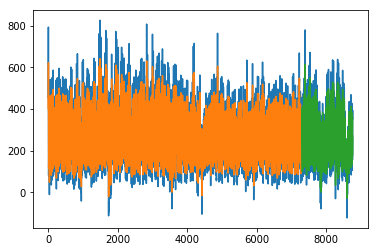

In [219]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

In [220]:
#Undo the Residuals

In [221]:
print(len(trainPredict))
print(len(testPredict))

7296
1459


In [222]:
dataframe = pandas.read_csv('Demand_Data3_2017_Total.csv', usecols=[4,3,15])
dataframe['Residuals'] = dataframe['passenger_count'] - dataframe['OLS_fitted_value']
dataframe = dataframe[dataframe['PULocationID'] == PULoc]
dataframe = dataframe['Residuals']
print(dataframe.values)

[455.1663753  529.9207638  782.2852665  ... 393.5290163  392.891366
 352.93202097]


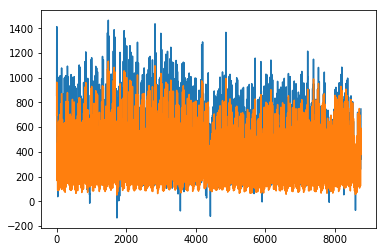

In [227]:

Predicted_Residuals = numpy.append(trainPredict,testPredict)
original = dataframe.values

Predicted = Predicted_Residuals  + original[:-4]
plt.plot(Predicted)

dataframe = pandas.read_csv('Demand_Data3_2017_Total.csv', usecols=[4,3,15])
dataframe = dataframe[dataframe['PULocationID'] == PULoc]
dataframe = dataframe['passenger_count']
dataset = dataframe.values
dataset = dataset.astype('float32')
dataset = numpy.reshape(dataset, (len(dataset),1))
plt.plot(dataset)

[405.6424  463.18777 650.94135 ... 188.65822 268.19272 268.34552]
